# Import necessary packages

For this tutorial, we will the rsa toolbox package: 
[RSA toolbox documentation](https://rsatoolbox.readthedocs.io/en/stable/)

In [ ]:
!pip install rsatoolbox

import numpy as np
import rsatoolbox as rsa
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import requests, io


base = f"https://raw.githubusercontent.com/barafat2/RSA_tutorial/main/data/"

files = ["patterns.npy", "info.tsv"]

# download and save
for f in files:
    url = base + f
    print("Downloading:", url)
    r = requests.get(url)
    with open(f, "wb") as outfile:
        outfile.write(r.content)


Downloading: https://raw.githubusercontent.com/barafat2/RSA_tutorial/main/data/patterns.npy
Downloading: https://raw.githubusercontent.com/barafat2/RSA_tutorial/main/data/info.tsv


# Load fMRI data and info file describing the data

In [3]:
X = np.load("data/patterns.npy")              
info = pd.read_csv("data/info.tsv", sep="\t")


check shape of the data, here rows are tasks x repitions (one per run) and columns are voxels

In [4]:
X.shape

(464, 6918)

check number of unique tasks, number of runs

In [5]:
n_unique_tasks = info['cond_name'].nunique()
print(f'Number of unique tasks: {n_unique_tasks}')
print(f"unique tasks are: {info['cond_name'].unique()}")

Number of unique tasks: 29
unique tasks are: ['NoGo' 'Go' 'ToM' 'VideoAct' 'VideoKnots' 'UnpleasantScenes'
 'PleasantScenes' 'Math' 'DigitJudgement' 'CheckerBoard' 'SadFaces'
 'HappyFaces' 'IntervalTiming' 'MotorImagery' 'FingerSimple' 'FingerSeq'
 'Verbal0Back' 'Verbal2Back' 'Object0Back' 'Object2Back'
 'SpatialNavigation' 'StroopIncon' 'StroopCon' 'VerbGen' 'WordRead'
 'VisualSearchSmall' 'VisualSearchMed' 'VisualSearchLarge' 'rest']


In [6]:
n_unique_runs = info['run'].nunique()
print(f'Number of runs: {n_unique_runs}')

Number of runs: 16


# Condition and partition vectors

The rsa toolbox expects two vectors to describe the data: 
- condition vector: which task is performed in each row of X
- partition vector: which run the data in each row of X belongs to

we can create these vectors using information about the data stored in the info dataframe, each condition gets a unique condition number and each run gets a unique partition number

In [7]:
cond_vec = np.tile(np.arange(1, n_unique_tasks+1), n_unique_runs)
part_vec = np.repeat(np.arange(1, n_unique_runs+1), n_unique_tasks)


# Calculating  RDMs

In [38]:
dataset = rsa.data.Dataset(X,channel_descriptors={'channel': np.array(['vox_' + str(x) for x in range(X.shape[-1])])},obs_descriptors={'conds': cond_vec,'run': part_vec,'cond_name': info['cond_name'].values})
rdm_obj = rsa.rdm.calc_rdm(dataset, method='crossnobis', descriptor='conds', cv_descriptor='run')
rdm = rdm_obj.get_matrices()[0]


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


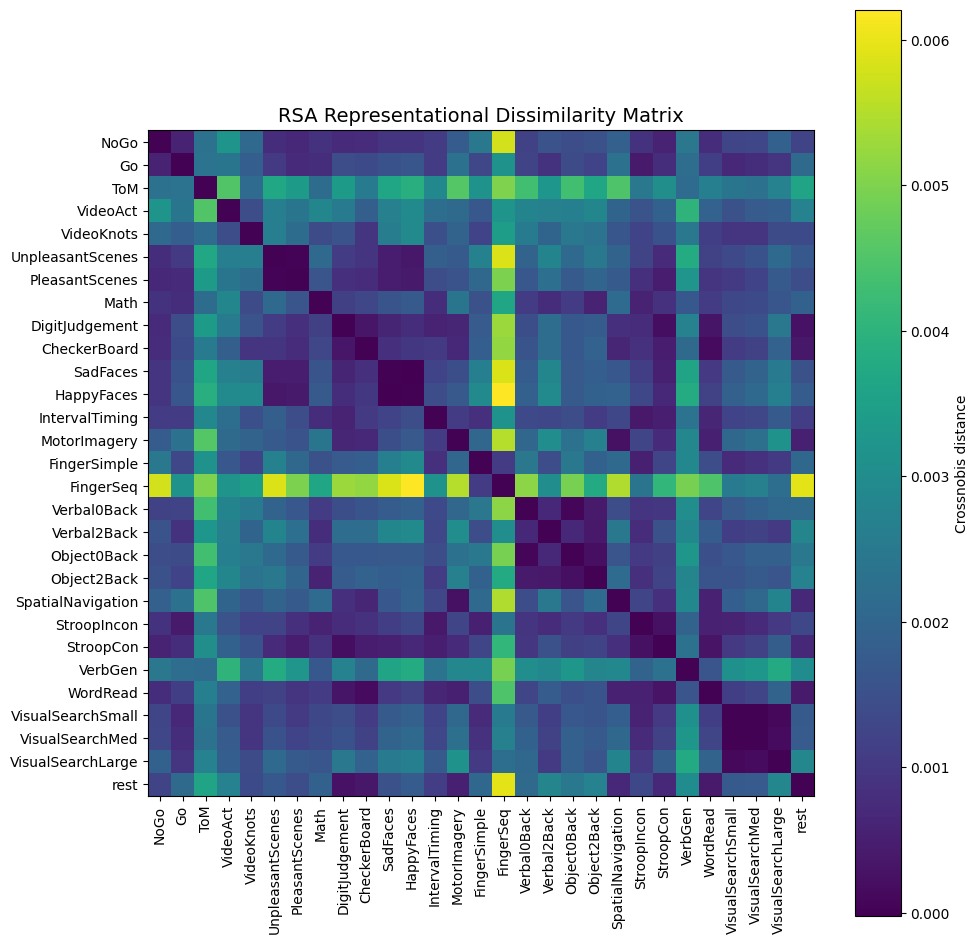

In [39]:
unique_labels = info['cond_name'].unique()

plt.figure(figsize=(10, 10))
plt.imshow(rdm, cmap='viridis', vmin=D.min(), vmax=D.max())
plt.colorbar(label="Crossnobis distance")

plt.xticks(np.arange(len(unique_labels)), unique_labels, rotation=90)
plt.yticks(np.arange(len(unique_labels)), unique_labels)

plt.title("RSA Representational Dissimilarity Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# testing model RDMs

model 1: IID tasks are all equally different

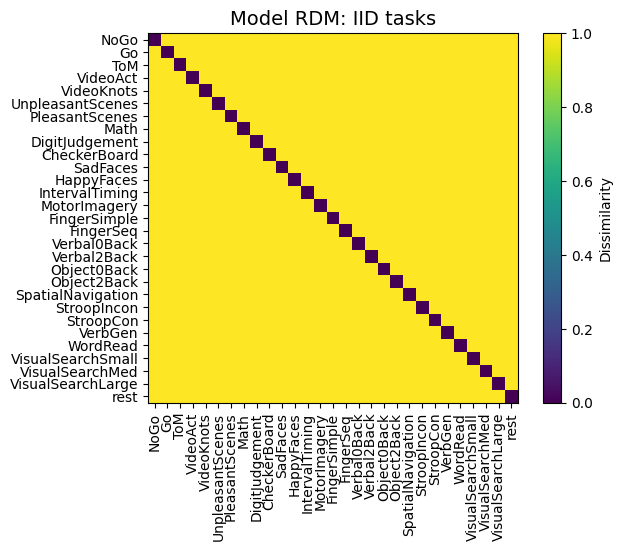

In [45]:
n = len(unique_labels)
model_rdm_iid = np.ones((n, n))
np.fill_diagonal(model_rdm_iid, 0)
plt.imshow(model_rdm_iid, cmap='viridis')
plt.title("Model RDM: IID tasks", fontsize=14)
plt.colorbar(label="Dissimilarity")
plt.xticks(np.arange(len(unique_labels)), unique_labels, rotation=90)
plt.yticks(np.arange(len(unique_labels)), unique_labels)
plt.show()


model 2 : motor vs cognitive tasks

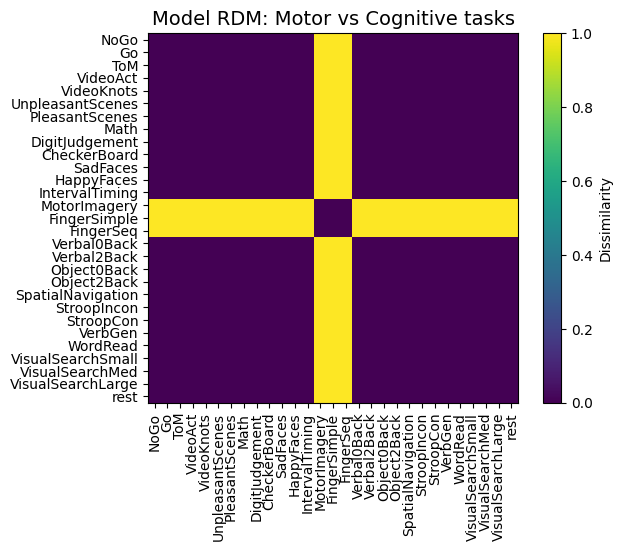

In [46]:
motor_tasks = ["MotorImagery", "FingerSimple", "FingerSeq"]

# 1 = motor, 0 = cognitive
group = np.array([1 if label in motor_tasks else 0 for label in unique_labels])

model_rdm_cogmotor = squareform(pdist(group[:, None], metric='cityblock'))

plt.imshow(model_rdm_cogmotor, cmap='viridis')
plt.title("Model RDM: Motor vs Cognitive tasks", fontsize=14)
plt.colorbar(label="Dissimilarity")
plt.xticks(np.arange(len(unique_labels)), unique_labels, rotation=90)
plt.yticks(np.arange(len(unique_labels)), unique_labels)
plt.show()


# compare brain RDM to model RDMs

In [48]:
brain_vec = rdm.flatten()
iid_vec = model_rdm_iid.flatten()
cogm_vec = model_rdm_cogmotor.flatten()


rho_iid, p_iid = pearsonr(brain_vec, iid_vec)
rho_cogm, p_cogm = pearsonr(brain_vec, cogm_vec)

print("Pearson corr with IID model:            ", rho_iid, " p =", p_iid)
print("Pearson corr with Cognitive/Motor model:", rho_cogm, " p =", p_cogm)

Pearson corr with IID model:             0.2880665130615283  p = 1.557240994224687e-17
Pearson corr with Cognitive/Motor model: 0.35581911510044134  p = 1.6696655999865176e-26
